---
title       : "Extremum estimation"
subtitle    :
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "ee.bib"
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 

### About this document {-}

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/GMMInference.jl). The same
document generates both static webpages and associated [jupyter
notebook](extremumEstimation.ipynb).

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\def\inprob{\,{\buildrel p \over \rightarrow}\,} 
\def\indist{\,{\buildrel d \over \rightarrow}\,} 
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end

"Agg"

# Extremum Estimation

Many, perhaps most, estimators in econometrics are extrumem
estimators. That is, many estimators are defined by

$$
\hat{\theta} = \argmax_{\theta \in \Theta}
\hat{Q}_n(\theta) 
$$

where $\hat{Q}_n(\theta)$ is some objective
function that depends on data. Examples include maximum likelihood, 

$$
\hat{Q}_n(\theta) = \frac{1}{n} \sum_{i=1}^n f(z_i | \theta) 
$$

GMM,

$$
\hat{Q}_n(\theta) = \left(\frac{1}{n} \sum_{i=1}^n g(z_i,
\theta)\right)' \hat{W} \left(\frac{1}{n} \sum_{i=1}^n g(z_i,
\theta)\right)
$$

and nonlinear least squares 

$$
\hat{Q}_n(\theta) =
\frac{1}{n} \sum_{i=1}^n (y_i - h(x_i,\theta))^2.  
$$ 

See Newey and McFadden (1994)[@newey1994] for more details and examples.

## Example: logit

As a simple example, let's look look at some code for estimating a
logit.

In [2]:
using Distributions, Optim, BenchmarkTools
import ForwardDiff
function simulate_logit(observations, β)
  x = randn(observations, length(β))
  y = (x*β + rand(Logistic(), observations)) .>= 0.0
  return((y=y,x=x))
end 

function logit_likelihood(β,y,x)
  p = map(xb -> cdf(Logistic(),xb), x*β)
  sum(log.(ifelse.(y, p, 1.0 .- p)))
end

n = 500
k = 3
β0 = ones(k)
(y,x) = simulate_logit(n,β0)
Q = β -> -logit_likelihood(β,y,x)
Q(β0)

239.82743361956494

Now we maximize the likelihood using a few different algorithms from [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl)

In [3]:
@btime optimize(Q, zeros(k), NelderMead())
@btime optimize(Q, zeros(k), BFGS(), autodiff = :forward)
@btime optimize(Q, zeros(k), NewtonTrustRegion(), autodiff =:forward)

  1.867 ms (1442 allocations: 1.90 MiB)
  594.518 μs (505 allocations: 1.17 MiB)
  2.203 ms (1161 allocations: 1.95 MiB)


 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.95e-01, 8.93e-01, 1.25e+00]
    Minimum:   2.369327e+02

 * Found with
    Algorithm:     Newton's Method (Trust Region)
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 8.05e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.41e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.40e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.28e-15 ≰ 0.0e+00
    |g(x)|                 = 8.02e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    23
    f(x) calls:    12
    ∇f(x) calls:   12
    ∇²f(x) calls:  7


### Aside: Reverse mode automatic differentiation

For functions $f:\R^n \to \R^m$, the work for forward automatic
differentiation increases linearly with $n$. This is because forward
automatic differentiation applies the chain rule to each of the $n$
inputs. An alternative, is reverse automatic differentiation. Reverse
automatic differentiation is also based on the chain rule, but it
works backward from $f$ through intermediate steps back to $x$. The
work needed here scales linearly with $m$. Since optimization problems
have $m=1$, reverse automatic differentiation can often work well. The
downsides of reverse automatic differentiation are that: (1) it can
require a large amount of memory and (2) it is more difficult to
implement. There are handful of Julia packages that provide reverse
automatic differentiation, but they have some limitations in terms of
what functions thay can differentiate. Flux.jl and Zygote.jl are two such packages.

In [4]:
using Optim, BenchmarkTools
import Zygote
dQr = β->Zygote.gradient(Q,β)[1]
dQf = β->ForwardDiff.gradient(Q,β)

@show dQr(β0) ≈ dQf(β0)

@btime dQf(β0)
@btime dQr(β0)

n = 500
k = 200
β0 = ones(k)
(y,x) = simulate_logit(n,β0)
Q = β -> -logit_likelihood(β,y,x)
dQr = β->Zygote.gradient(Q,β)[1]
dQf = β->ForwardDiff.gradient(Q,β)
@show dQr(β0) ≈dQf(β0)
@btime dQf(β0);
@btime dQr(β0);

┌ Info: Recompiling stale cache file /home/paul/.julia/compiled/v1.2/Zygote/4kbLI.ji for Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1240


dQr(β0) ≈ dQf(β0) = true
  24.529 μs (9 allocations: 47.73 KiB)
  264.870 μs (14720 allocations: 467.53 KiB)
dQr(β0) ≈ dQf(β0) = true
  6.294 ms (157 allocations: 2.56 MiB)
  711.980 μs (14721 allocations: 1.21 MiB)


# Review of extremum estimator theory

This is based on Newey and McFadden (1994)[@newey1994]. You should already be familiar with this
from 627, so we will just state some basic "high-level" conditions for
consistency and asymptotic normality. 

## Consistency


!!! tip "**Theorem:** consistency for extremum estimators"
    Assume

    1. $\hat{Q}_n(\theta)$ converges uniformly in probability to
    $Q_0(\theta)$

    2. $Q_0(\theta)$ is uniquely maximized at $\theta_0$.

    3. $\Theta$ is compact and $Q_0(\theta)$ is continuous.

    Then $\hat{\theta} \inprob \theta_0$
    

## Asymptotic normality


!!! tip "**Theorem:** asymptotic normality for extremum estimators"
    Assume
    
    1. $\hat{\theta} \inprob \theta_0$
        
    2. $\theta_0 \in interior(\Theta)$
        
    3. $\hat{Q}_n(\theta)$ is twice continuously differentiable in
    open $N$ containing $\theta$ , and 
    $\sup_{\theta \in N} \Vert \nabla^2 \hat{Q}_n(\theta) - H(\theta) \Vert \inprob 0$ 
    with $H(\theta_0)$ nonsingular
        
    4. $\sqrt{n} \nabla \hat{Q}_n(\theta_0) \indist N(0,\Sigma)$
       
    Then $\sqrt{n} (\hat{\theta} - \theta_0) \indist N\left(0,H^{-1} \Sigma H^{-1} \right)$

Implementing this in Julia using automatic differentiation is straightforward.

In [5]:
function logit_likei(β,y,x)
  p = map(xb -> cdf(Logistic(),xb), x*β)
  log.(ifelse.(y, p, 1.0 .- p))
end

function logit_likelihood(β,y,x)
  mean(logit_likei(β,y,x))
end

n = 1000
k = 3
β0 = ones(k)
(y,x) = simulate_logit(n,β0)
      
Q = β -> -logit_likelihood(β,y,x)      
optres = optimize(Q, zeros(k), NewtonTrustRegion(), autodiff =:forward)
βhat = optres.minimizer

function asymptotic_variance(Q,dQi, θ)
  gi = dQi(θ)
  Σ = gi'*gi/size(gi)[1]
  H = ForwardDiff.hessian(Q,θ)
  invH = inv(H)
  (variance=invH*Σ*invH, Σ=Σ, invH=invH)
end

avar=asymptotic_variance(θ->logit_likelihood(θ,y,x),
                         θ->ForwardDiff.jacobian(β->logit_likei(β,y,x),θ),βhat)
display( avar.variance/n)
display( -avar.invH/n)
display(inv(avar.Σ)/n)

3×3 Array{Float64,2}:
 0.00772756  0.0025565   0.00202042
 0.0025565   0.00852367  0.00183648
 0.00202042  0.00183648  0.00718848

3×3 Array{Float64,2}:
 0.0079698   0.00241206  0.00238538
 0.00241206  0.00845679  0.00229233
 0.00238538  0.00229233  0.00791892

3×3 Array{Float64,2}:
 0.0082436   0.00228938  0.00278224
 0.00228938  0.00843069  0.00278527
 0.00278224  0.00278527  0.00873384

For maximum likelihood, the information equality says $-H = \Sigma$,
so the three expressions above have the same probability limit, and
are each consistent estimates of the variance of $\hat{\theta}$.

The code above is for demonstration and learning. If we really wanted
to estimate a logit for research, it would be better to use a
well-tested package. Here's how to estimate  a logit using GLM.jl.

In [6]:
using GLM, DataFrames
df = DataFrame(x)
df[:y] = y
glmest=glm(@formula(y ~ -1 + x1+x2+x3), df, Binomial(),LogitLink())
display( glmest)
display( vcov(glmest))

┌ Info: Recompiling stale cache file /home/paul/.julia/compiled/v1.2/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/paul/.julia/compiled/v1.2/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1240


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 0 + x1 + x2 + x3

Coefficients:
─────────────────────────────────────────────────────────────────
    Estimate  Std. Error  z value  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────
x1  0.922683   0.0892665  10.3363    <1e-24   0.747724    1.09764
x2  0.975343   0.0919535  10.6069    <1e-25   0.795118    1.15557
x3  0.963636   0.088981   10.8297    <1e-26   0.789236    1.13804
─────────────────────────────────────────────────────────────────

3×3 Array{Float64,2}:
 0.00796851  0.00241121  0.00238454
 0.00241121  0.00845544  0.00229147
 0.00238454  0.00229147  0.00791762

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[6]:3
└ @ Core In[6]:3


## Delta method

In many models, we are interested in some transformation of the
parameters in addition to the parameters themselves. For example, in a
logit, we might want to report marginal effects in addition to the
coefficients. In structural models, we typically use the parameter
estimates to conduct counterfactual simulations. In many 
situations we are more interested these transformation(s) of
parameters than in the parameters themselves. The delta method is one
convenient way to approximate the distribution of transformations of 
the model parameters. 

!!! tip "**Theorem:** Delta method"
    Assume:
    
    1. $\sqrt{n} (\hat{\theta} - \theta_0) \indist N(0,\Omega)$
    
    2. $g: \R^k \to \R^m$ is continuously differentiable
    
    Then $\sqrt{n}(g(\hat{\theta}) - g(\theta_0)) \indist N(0, \nabla g(\theta_0)^T \Omega \nabla g(\theta_0)$

The following code uses the delta method to plot a 90% pointwise
confidence band around the estimate marginal effect of one of the
regressors.

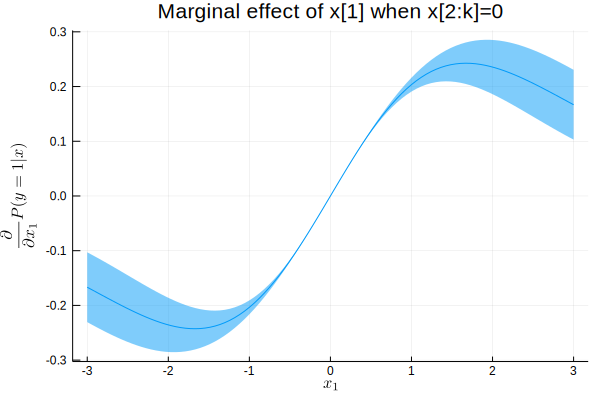

In [7]:
using LinearAlgebra
function logit_mfx(β,x)
  ForwardDiff.jacobian(β-> map(xb -> cdf(Logistic(),xb), x*β), β)  
end

function delta_method(g, θ, Ω)
  dG = ForwardDiff.jacobian(θ->g(θ),θ)
  dG*Ω*dG'  
end

nfx = 100
xmfx = zeros(nfx,3)
xmfx[:,1] .= -3.0:(6.0/(nfx-1)):3.0

mfx = logit_mfx(βhat,xmfx)
vmfx = delta_method(β->logit_mfx(β,xmfx)[:,1], βhat, avar.variance/n)
sdfx = sqrt.(diag(vmfx))

using Plots, LaTeXStrings
Plots.gr()
plot(xmfx[:,1],mfx[:,1],ribbon=quantile(Normal(),0.95)*sdfx,fillalpha=0.5,
     xlabel=L"x_1", ylabel=L"\frac{\partial}{\partial x_1}P(y=1|x)", legend=false,
         title="Marginal effect of x[1] when x[2:k]=0")

The same approach can be used to compute standard errors and
confidence regions for the results of more complicated counterfactual
simulations, as long as the associated simulations are smooth
functions of the parameters. However, sometimes it might be more
natural to write simulations with outcomes that are not smooth in the
parameters. For example, the following code uses simulation to
calculate the change in the probability of $y$ from adding 0.1 to
$x$.

In [8]:
function counterfactual_sim(β, x, S)
  function onesim()
    e = rand(Logistic(), size(x)[1])
    baseline= (x*β .+ e .> 0)
    counterfactual= ((x.+0.1)*β .+ e .> 0)
    mean(counterfactual.-baseline)
  end
  mean([onesim() for s in 1:S])
end
ForwardDiff.gradient(β->counterfactual_sim(β,x,10),βhat)

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Here, the gradient is 0 because the simulation function is a
step-function. In this situation, an alternative to the delta method
is the simulation based approach of Krinsky and Robb (1986)[@krinsky1986]. The procedure is
quite simple. Suppose 
$\sqrt{n}(\hat{\theta} - \theta_0) \indist N(0,\Omega)$,
and you want to an estimate of the distribution of $g(\theta)$. 
Repeatedly draw $\theta_s \sim N(\hat{\theta}, \Omega/n)$ and compute
$g(\theta_s)$. Use the distribution of $g(\theta_s)$ for
inference. For example, a 90% confidence interval for $g(\theta)$
would be the 5%-tile of $g(\theta_s)$ to the 95%-tile of
$g(\theta_s)$.

In [9]:
Ω = avar.variance/n
Ω = (Ω+Ω')/2         # otherwise, it's not exactly symmetric due to
                     # floating point roundoff
function kr_confint(g, θ, Ω, simulations; coverage=0.9)
  θs = [g(rand(MultivariateNormal(θ,Ω))) for s in 1:simulations]
  quantile(θs, [(1.0-coverage)/2, coverage + (1.0-coverage)/2])
end

@show kr_confint(β->counterfactual_sim(β,x,10), βhat, Ω, 1000)

# a delta method based confidence interval for the same thing
function counterfactual_calc(β, x)
  baseline      = cdf.(Logistic(), x*β)
  counterfactual= cdf.(Logistic(), (x.+0.1)*β)
  return([mean(counterfactual.-baseline)])
end
v = delta_method(β->counterfactual_calc(β,x), βhat, Ω)
ghat = counterfactual_calc(βhat,x)
@show [ghat + sqrt(v)*quantile(Normal(),0.05), ghat +
       sqrt(v)*quantile(Normal(),0.95)]

kr_confint((β->begin
            #= In[9]:9 =#
            counterfactual_sim(β, x, 10)
        end), βhat, Ω, 1000) = [0.04519499999999999, 0.05399999999999999]
[ghat + sqrt(v) * quantile(Normal(), 0.05), ghat + sqrt(v) * quantile(Normal(), 0.95)] = Array{Float64,2}[[0.046824962081034774], [0.052463997901948695]]


2-element Array{Array{Float64,2},1}:
 [0.046824962081034774]
 [0.052463997901948695]

# References

\bibliography